# Regresión Logística vs VQC

In [2]:
!pip install qiskit==0.44.0 qiskit-machine-learning==0.6.0 qiskit-aer==0.12.0 scikit-learn==1.1.3 numpy==1.23.5

## Preparación de los datos

In [3]:
import pandas as pd

data = pd.read_csv("data.csv")

data.head()

,category,amt,state,lat,long,is_fraud,hora,dia,mes,edad,card_type,previous_fraud_client,previous_fraud_merchant,gender_M,periodo_dia_noche,periodo_dia_tarde
0,0.002404,91.82,0.005391,41.6060,-109.2300,0,12,5,8,36,0.005559,1.0,1.0,False,False,False
1,0.001621,38.60,0.005991,37.0581,-86.1938,0,12,5,8,21,0.005652,1.0,1.0,False,False,False
2,0.013720,104.39,0.006025,44.8232,-89.1665,0,7,5,8,66,0.005652,1.0,1.0,True,False,False
3,0.013989,3.68,0.005193,46.5901,-117.1692,0,10,5,8,77,0.005652,1.0,1.0,False,False,False
4,0.013989,1.61,0.006197,42.1939,-76.7361,0,8,5,8,29,0.004766,1.0,1.0,False,False,False


In [4]:
data_2 = data.drop(['state', 'lat', 'long', 'hora', 'dia', 'mes', 'gender_M', 'periodo_dia_tarde'], axis=1)

data_2.columns

Index(['category', 'amt', 'is_fraud', 'edad', 'card_type',
       'previous_fraud_client', 'previous_fraud_merchant',
       'periodo_dia_noche'],
      dtype='object')

## Estudio Comparativo (Desbalanceo 75-25)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def crear_submuestra_balanceada(df, label_col, total_muestra, proporcion_clase_mayor=0.75):
    # Contar clases
    clases = df['is_fraud'].unique()
    if len(clases) != 2:
        raise ValueError("Este método está pensado para problemas binarios (dos clases).")

    # Determinar cuántas instancias tomar de cada clase
    n_mayor = int(total_muestra * proporcion_clase_mayor)
    n_menor = total_muestra - n_mayor

    # Detectar qué clase es la mayor
    conteos = df['is_fraud'].value_counts()
    clase_mayor = conteos.idxmax()
    clase_menor = conteos.idxmin()

    # Tomar muestras aleatorias
    df_mayor = df[df['is_fraud'] == clase_mayor].sample(n=n_mayor, random_state=42)
    df_menor = df[df['is_fraud'] == clase_menor].sample(n=n_menor, random_state=42)

    # Combinar y mezclar
    df_final = pd.concat([df_mayor, df_menor]).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_final

# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500)

### 200 datos

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### Regresión Lineal

In [7]:
from sklearn.linear_model import LogisticRegression

# Creamos y entrenamos el modelo de regresión logística.
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_1, y_train_1)

LogisticRegression(max_iter=1000)

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Hacemos las predicciones.
y_lr_pred_1 = lr.predict(x_test_1)

# Calculamos métricas.
acc_lr_200_1 = accuracy_score(y_test_1, y_lr_pred_1)
print("Accuracy:", acc_lr_200_1)
prec_lr_200_1 = precision_score(y_test_1, y_lr_pred_1)
print("Precisión:", prec_lr_200_1)
recall_lr_200_1 = recall_score(y_test_1, y_lr_pred_1)
print("Recall:", recall_lr_200_1)
f1_lr_200_1 = f1_score(y_test_1, y_lr_pred_1)
print("F1 Score:", f1_lr_200_1)
print(classification_report(y_test_1, y_lr_pred_1))

Accuracy: 0.9166666666666666
Precisión: 1.0
Recall: 0.6666666666666666
F1 Score: 0.8
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        45
         1.0       1.00      0.67      0.80        15

    accuracy                           0.92        60
   macro avg       0.95      0.83      0.87        60
weighted avg       0.93      0.92      0.91        60



#### VQC con COBYLA

In [9]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, EfficientSU2
from qiskit_machine_learning.algorithms import VQC
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit_aer import Aer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_1)
x_test_scaled = scaler.transform(x_test_1)

In [10]:
# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)
print(feature_map.decompose())

     ┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_4: ┤ H ├┤ P(2.0*x[4]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_5: ┤ H ├┤ P(2.0*x[5]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_6: ┤ H ├┤ P(2.0*x[6]) ├─────────────

In [11]:
# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')
print(ansatz.decompose())

     ┌──────────┐                                    ┌──────────┐      »
q_0: ┤ Ry(θ[0]) ├─■──■─────■─────■────────■────────■─┤ Ry(θ[7]) ├──────»
     ├──────────┤ │  │     │     │        │        │ └──────────┘      »
q_1: ┤ Ry(θ[1]) ├─■──┼──■──┼──■──┼─────■──┼─────■──┼─────────────────■─»
     ├──────────┤    │  │  │  │  │     │  │     │  │                 │ »
q_2: ┤ Ry(θ[2]) ├────■──■──┼──┼──┼──■──┼──┼──■──┼──┼──────────────■──┼─»
     ├──────────┤          │  │  │  │  │  │  │  │  │              │  │ »
q_3: ┤ Ry(θ[3]) ├──────────■──■──┼──■──┼──┼──┼──┼──┼──────■───────┼──┼─»
     ├──────────┤                │     │  │  │  │  │      │       │  │ »
q_4: ┤ Ry(θ[4]) ├────────────────■─────■──┼──■──┼──┼──────■───────┼──┼─»
     ├──────────┤                         │     │  │              │  │ »
q_5: ┤ Ry(θ[5]) ├─────────────────────────■─────■──┼──────────────■──┼─»
     ├──────────┤                                  │                 │ »
q_6: ┤ Ry(θ[6]) ├──────────────────────────────────

In [12]:
# Usamos un sampler para el backend.
sampler = AerSampler()

# Definimos callback para guardar losses y plotear al final.
def callback(weights, loss):
    losses.append(loss)
    print(f"Loss: {loss:.4f}")

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0067
Loss: 1.0129
Loss: 0.9985
Loss: 0.9924
Loss: 1.0042
Loss: 1.0058
Loss: 0.9971
Loss: 0.9815
Loss: 1.0053
Loss: 0.9783
Loss: 0.9886
Loss: 0.9954
Loss: 0.9938
Loss: 0.9896
Loss: 0.9877
Loss: 1.0022
Loss: 0.9832
Loss: 0.9748
Loss: 0.9858
Loss: 0.9726
Loss: 0.9809
Loss: 0.9731
Loss: 0.9846
Loss: 0.9798
Loss: 0.9767
Loss: 0.9823
Loss: 0.9726
Loss: 0.9744
Loss: 0.9745
Loss: 0.9795
Loss: 0.9644
Loss: 0.9736
Loss: 0.9649
Loss: 0.9825
Loss: 0.9640
Loss: 0.9742
Loss: 0.9661
Loss: 0.9615
Loss: 0.9582
Loss: 0.9753
Loss: 0.9538
Loss: 0.9848
Loss: 0.9553
Loss: 0.9694
Loss: 0.9606
Loss: 0.9749
Loss: 0.9551
Loss: 0.9697
Loss: 0.9458
Loss: 0.9356
Loss: 0.9438
Loss: 0.9381
Loss: 0.9364
Loss: 0.9348
Loss: 0.9449
Loss: 0.9547
Loss: 0.9327
Loss: 0.9456
Loss: 0.9297
Loss: 0.9591
Loss: 0.9339
Loss: 0.9487
Loss: 0.9194
Loss: 0.9598
Loss: 0.9333
Loss: 0.9484
Loss: 0.9327
Loss: 0.9663
Loss: 0.9370
Loss: 0.9488
Loss: 0.9438
Loss: 0.9498
Loss: 0.9441
Loss: 0.9369
Loss: 0.9397
Loss: 0.9500
Loss: 0.9280

Tiempo: 7m

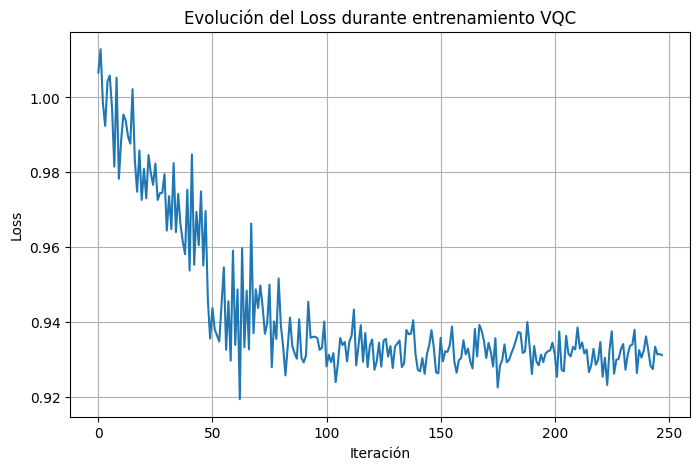

In [13]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [14]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_cobyla_200_1 = accuracy_score(y_test_1, y_pred)
prec_vqc_cobyla_200_1 = precision_score(y_test_1, y_pred)
recall_vqc_cobyla_200_1 = recall_score(y_test_1, y_pred)
f1_vqc_cobyla_200_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_cobyla_200_1)
print("Precisión:", prec_vqc_cobyla_200_1)
print("Recall:", recall_vqc_cobyla_200_1)
print("F1 score:", f1_vqc_cobyla_200_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.55
Precisión: 0.2857142857142857
Recall: 0.5333333333333333
F1 score: 0.37209302325581395
              precision    recall  f1-score   support

         0.0       0.78      0.56      0.65        45
         1.0       0.29      0.53      0.37        15

    accuracy                           0.55        60
   macro avg       0.53      0.54      0.51        60
weighted avg       0.66      0.55      0.58        60



#### VQC con SPSA

In [15]:
from qiskit.algorithms.optimizers import SPSA

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

In [16]:
# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con SPSA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=SPSA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0077
Loss: 1.0140
Loss: 1.0081
Loss: 1.0054
Loss: 1.0090
Loss: 1.0255
Loss: 1.0102
Loss: 1.0251
Loss: 0.9954
Loss: 1.0327
Loss: 1.0150
Loss: 1.0039
Loss: 0.9927
Loss: 1.0272
Loss: 1.0098
Loss: 0.9976
Loss: 1.0101
Loss: 1.0115
Loss: 1.0276
Loss: 1.0083
Loss: 1.0180
Loss: 1.0104
Loss: 1.0171
Loss: 1.0151
Loss: 1.0141
Loss: 1.0212
Loss: 1.0295
Loss: 1.0215
Loss: 0.9999
Loss: 1.0175
Loss: 1.0285
Loss: 1.0137
Loss: 1.0299
Loss: 0.9935
Loss: 1.0246
Loss: 1.0280
Loss: 1.0296
Loss: 0.9984
Loss: 1.0086
Loss: 1.0285
Loss: 1.0097
Loss: 0.9990
Loss: 1.0129
Loss: 1.0060
Loss: 1.0081
Loss: 1.0117
Loss: 1.0073
Loss: 1.0244
Loss: 1.0296
Loss: 1.0088
Loss: 1.0127
Loss: 1.0128
Loss: 1.0294
Loss: 1.0021
Loss: 1.0039
Loss: 0.9964
Loss: 1.0078
Loss: 0.9964
Loss: 0.9900
Loss: 0.9931
Loss: 1.0053
Loss: 0.9926
Loss: 0.9950
Loss: 1.0082
Loss: 0.9829
Loss: 0.9859
Loss: 1.0038
Loss: 0.9982
Loss: 0.9866
Loss: 1.0010
Loss: 0.9947
Loss: 0.9843
Loss: 0.9894
Loss: 0.9822
Loss: 0.9821
Loss: 0.9800
Loss: 0.9722

Tiempo: 27m

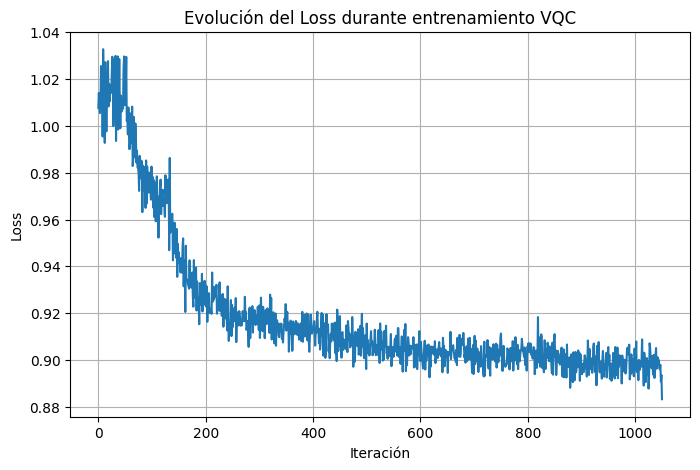

In [17]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [18]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_spsa_200_1 = accuracy_score(y_test_1, y_pred)
prec_vqc_spsa_200_1 = precision_score(y_test_1, y_pred)
recall_vqc_spsa_200_1 = recall_score(y_test_1, y_pred)
f1_vqc_spsa_200_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_spsa_200_1)
print("Precisión:", prec_vqc_spsa_200_1)
print("Recall:", recall_vqc_spsa_200_1)
print("F1 score:", f1_vqc_spsa_200_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.65
Precisión: 0.3125
Recall: 0.3333333333333333
F1 score: 0.3225806451612903
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76        45
         1.0       0.31      0.33      0.32        15

    accuracy                           0.65        60
   macro avg       0.54      0.54      0.54        60
weighted avg       0.66      0.65      0.65        60



### 500 datos

In [19]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### Regresión Lineal

In [20]:
# Creamos y entrenamos el modelo de regresión logística.
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_1, y_train_1)

LogisticRegression(max_iter=1000)

In [21]:
# Hacemos las predicciones.
y_lr_pred_1 = lr.predict(x_test_1)

# Calculamos métricas.
acc_lr_500_1 = accuracy_score(y_test_1, y_lr_pred_1)
print("Accuracy:", acc_lr_500_1)
prec_lr_500_1 = precision_score(y_test_1, y_lr_pred_1)
print("Precisión:", prec_lr_500_1)
recall_lr_500_1 = recall_score(y_test_1, y_lr_pred_1)
print("Recall:", recall_lr_500_1)
f1_lr_500_1 = f1_score(y_test_1, y_lr_pred_1)
print("F1 Score:", f1_lr_500_1)
print(classification_report(y_test_1, y_lr_pred_1))

Accuracy: 0.9266666666666666
Precisión: 0.9642857142857143
Recall: 0.7297297297297297
F1 Score: 0.8307692307692307
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95       113
         1.0       0.96      0.73      0.83        37

    accuracy                           0.93       150
   macro avg       0.94      0.86      0.89       150
weighted avg       0.93      0.93      0.92       150



#### VQC con COBYLA

In [22]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_1)
x_test_scaled = scaler.transform(x_test_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

In [23]:
# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 0.9948
Loss: 1.0087
Loss: 0.9923
Loss: 0.9893
Loss: 0.9932
Loss: 1.0005
Loss: 1.0026
Loss: 0.9848
Loss: 0.9964
Loss: 0.9823
Loss: 0.9851
Loss: 0.9790
Loss: 0.9779
Loss: 0.9834
Loss: 0.9856
Loss: 1.0077
Loss: 0.9818
Loss: 0.9892
Loss: 0.9786
Loss: 0.9840
Loss: 0.9852
Loss: 0.9876
Loss: 0.9950
Loss: 0.9826
Loss: 0.9769
Loss: 0.9813
Loss: 0.9808
Loss: 0.9852
Loss: 0.9802
Loss: 0.9714
Loss: 1.0081
Loss: 0.9722
Loss: 0.9748
Loss: 0.9759
Loss: 0.9694
Loss: 0.9750
Loss: 0.9796
Loss: 0.9686
Loss: 0.9739
Loss: 0.9665
Loss: 0.9756
Loss: 0.9679
Loss: 0.9872
Loss: 0.9697
Loss: 0.9650
Loss: 0.9680
Loss: 0.9715
Loss: 0.9670
Loss: 0.9671
Loss: 0.9683
Loss: 0.9698
Loss: 0.9678
Loss: 0.9730
Loss: 0.9702
Loss: 0.9723
Loss: 0.9699
Loss: 0.9697
Loss: 0.9644
Loss: 0.9979
Loss: 0.9703
Loss: 0.9699
Loss: 0.9744
Loss: 0.9686
Loss: 0.9742
Loss: 0.9691
Loss: 0.9701
Loss: 0.9713
Loss: 0.9687
Loss: 0.9722
Loss: 0.9703
Loss: 0.9667
Loss: 0.9735
Loss: 0.9691
Loss: 0.9693
Loss: 0.9723
Loss: 0.9691
Loss: 0.9639

Tiempo: 21m

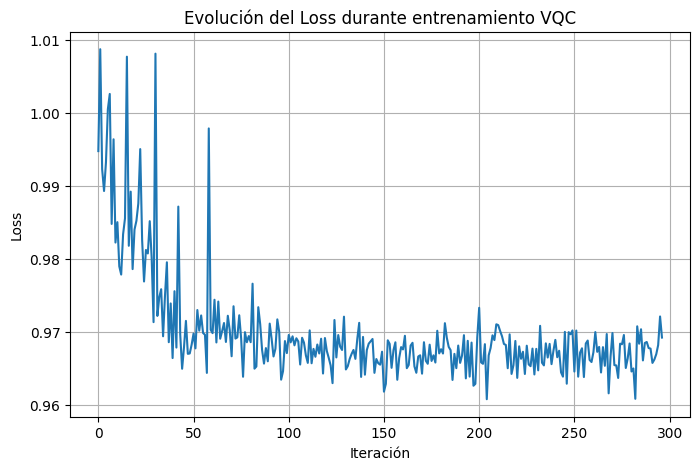

In [24]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [25]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_cobyla_500_1 = accuracy_score(y_test_1, y_pred)
prec_vqc_cobyla_500_1 = precision_score(y_test_1, y_pred)
recall_vqc_cobyla_500_1 = recall_score(y_test_1, y_pred)
f1_vqc_cobyla_500_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_cobyla_500_1)
print("Precisión:", prec_vqc_cobyla_500_1)
print("Recall:", recall_vqc_cobyla_500_1)
print("F1 score:", f1_vqc_cobyla_500_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.54
Precisión: 0.2647058823529412
Recall: 0.4864864864864865
F1 score: 0.34285714285714286
              precision    recall  f1-score   support

         0.0       0.77      0.56      0.65       113
         1.0       0.26      0.49      0.34        37

    accuracy                           0.54       150
   macro avg       0.52      0.52      0.49       150
weighted avg       0.64      0.54      0.57       150



#### VQC con SPSA

In [26]:
# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

In [27]:
# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con SPSA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=SPSA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 0.9979
Loss: 0.9969
Loss: 0.9990
Loss: 1.0024
Loss: 1.0166
Loss: 0.9994
Loss: 0.9944
Loss: 1.0012
Loss: 1.0066
Loss: 1.0006
Loss: 1.0146
Loss: 1.0050
Loss: 1.0145
Loss: 1.0018
Loss: 1.0030
Loss: 0.9995
Loss: 1.0116
Loss: 0.9977
Loss: 0.9997
Loss: 1.0037
Loss: 1.0136
Loss: 0.9952
Loss: 1.0069
Loss: 1.0154
Loss: 1.0141
Loss: 1.0011
Loss: 1.0121
Loss: 1.0029
Loss: 0.9943
Loss: 1.0145
Loss: 1.0120
Loss: 0.9983
Loss: 1.0066
Loss: 0.9939
Loss: 1.0009
Loss: 1.0041
Loss: 1.0045
Loss: 0.9935
Loss: 1.0009
Loss: 1.0109
Loss: 1.0054
Loss: 0.9940
Loss: 1.0047
Loss: 1.0046
Loss: 1.0074
Loss: 0.9998
Loss: 1.0128
Loss: 0.9985
Loss: 1.0048
Loss: 0.9982
Loss: 1.0080
Loss: 1.0062
Loss: 0.9986
Loss: 1.0105
Loss: 0.9947
Loss: 0.9918
Loss: 0.9898
Loss: 0.9911
Loss: 0.9921
Loss: 0.9878
Loss: 0.9865
Loss: 0.9903
Loss: 0.9914
Loss: 0.9870
Loss: 0.9776
Loss: 0.9908
Loss: 0.9790
Loss: 0.9881
Loss: 0.9675
Loss: 0.9787
Loss: 0.9704
Loss: 0.9665
Loss: 0.9732
Loss: 0.9636
Loss: 0.9688
Loss: 0.9699
Loss: 0.9711

Tiempo: 1h 30m

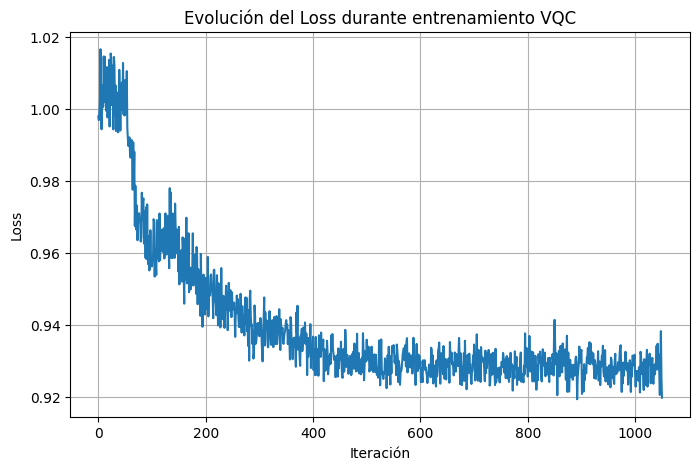

In [28]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [29]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_spsa_500_1 = accuracy_score(y_test_1, y_pred)
prec_vqc_spsa_500_1 = precision_score(y_test_1, y_pred)
recall_vqc_spsa_500_1 = recall_score(y_test_1, y_pred)
f1_vqc_spsa_500_1 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_spsa_500_1)
print("Precisión:", prec_vqc_spsa_500_1)
print("Recall:", recall_vqc_spsa_500_1)
print("F1 score:", f1_vqc_spsa_500_1)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.5933333333333334
Precisión: 0.22727272727272727
Recall: 0.2702702702702703
F1 score: 0.24691358024691357
              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72       113
         1.0       0.23      0.27      0.25        37

    accuracy                           0.59       150
   macro avg       0.49      0.48      0.48       150
weighted avg       0.62      0.59      0.60       150



## Estudio Comparativo (Sin Desbalanceo)

In [30]:
# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200, proporcion_clase_mayor=0.5)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500, proporcion_clase_mayor=0.5)

### 200 datos

In [31]:
x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### Regresión Lineal

In [32]:
# Creamos y entrenamos el modelo de regresión logística.
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_1, y_train_1)

LogisticRegression(max_iter=1000)

In [33]:
# Hacemos las predicciones.
y_lr_pred_1 = lr.predict(x_test_1)

# Calculamos métricas.
acc_lr_200_2 = accuracy_score(y_test_1, y_lr_pred_1)
print("Accuracy:", acc_lr_200_2)
prec_lr_200_2 = precision_score(y_test_1, y_lr_pred_1)
print("Precisión:", prec_lr_200_2)
recall_lr_200_2 = recall_score(y_test_1, y_lr_pred_1)
print("Recall:", recall_lr_200_2)
f1_lr_200_2 = f1_score(y_test_1, y_lr_pred_1)
print("F1 Score:", f1_lr_200_2)
print(classification_report(y_test_1, y_lr_pred_1))

Accuracy: 0.8166666666666667
Precisión: 0.88
Recall: 0.7333333333333333
F1 Score: 0.8
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83        30
         1.0       0.88      0.73      0.80        30

    accuracy                           0.82        60
   macro avg       0.83      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60



#### VQC con COBYLA

In [34]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_1)
x_test_scaled = scaler.transform(x_test_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

In [35]:
# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0123
Loss: 1.0167
Loss: 0.9970
Loss: 0.9959
Loss: 1.0152
Loss: 1.0099
Loss: 1.0156
Loss: 1.0174
Loss: 0.9808
Loss: 1.0066
Loss: 0.9808
Loss: 0.9811
Loss: 0.9866
Loss: 0.9740
Loss: 0.9898
Loss: 1.0004
Loss: 0.9850
Loss: 0.9832
Loss: 0.9828
Loss: 0.9898
Loss: 0.9806
Loss: 0.9738
Loss: 1.0074
Loss: 0.9839
Loss: 0.9807
Loss: 0.9832
Loss: 0.9840
Loss: 0.9805
Loss: 0.9775
Loss: 0.9722
Loss: 0.9758
Loss: 0.9816
Loss: 0.9648
Loss: 0.9503
Loss: 0.9652
Loss: 0.9849
Loss: 0.9589
Loss: 0.9650
Loss: 0.9563
Loss: 0.9709
Loss: 0.9525
Loss: 0.9605
Loss: 0.9569
Loss: 0.9503
Loss: 0.9575
Loss: 0.9392
Loss: 0.9485
Loss: 0.9800
Loss: 0.9504
Loss: 0.9627
Loss: 0.9507
Loss: 0.9507
Loss: 0.9502
Loss: 0.9506
Loss: 0.9462
Loss: 0.9546
Loss: 0.9572
Loss: 0.9489
Loss: 0.9610
Loss: 0.9491
Loss: 0.9572
Loss: 0.9523
Loss: 0.9541
Loss: 0.9607
Loss: 0.9559
Loss: 0.9564
Loss: 0.9477
Loss: 0.9488
Loss: 0.9535
Loss: 0.9505
Loss: 0.9689
Loss: 0.9510
Loss: 0.9629
Loss: 0.9485
Loss: 0.9489
Loss: 0.9492
Loss: 0.9588

Tiempo: 7m

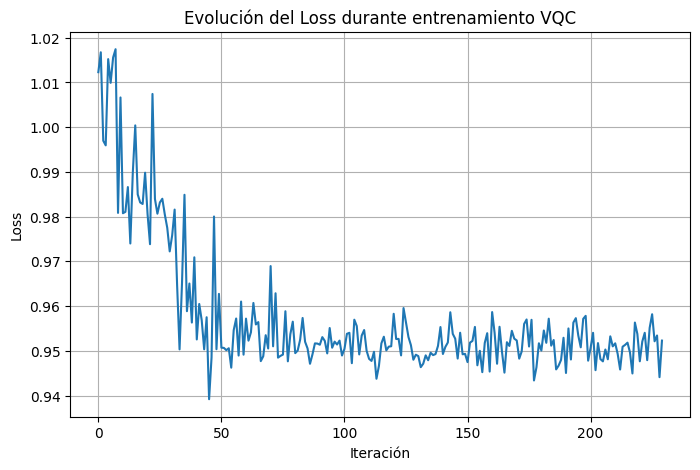

In [36]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [37]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_cobyla_200_2 = accuracy_score(y_test_1, y_pred)
prec_vqc_cobyla_200_2 = precision_score(y_test_1, y_pred)
recall_vqc_cobyla_200_2 = recall_score(y_test_1, y_pred)
f1_vqc_cobyla_200_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_cobyla_200_2)
print("Precisión:", prec_vqc_cobyla_200_2)
print("Recall:", recall_vqc_cobyla_200_2)
print("F1 score:", f1_vqc_cobyla_200_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.4166666666666667
Precisión: 0.4358974358974359
Recall: 0.5666666666666667
F1 score: 0.4927536231884058
              precision    recall  f1-score   support

         0.0       0.38      0.27      0.31        30
         1.0       0.44      0.57      0.49        30

    accuracy                           0.42        60
   macro avg       0.41      0.42      0.40        60
weighted avg       0.41      0.42      0.40        60



#### VQC con SPSA

In [38]:
# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

In [39]:
# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con SPSA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=SPSA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0466
Loss: 1.0196
Loss: 1.0280
Loss: 1.0246
Loss: 1.0341
Loss: 1.0226
Loss: 1.0357
Loss: 1.0443
Loss: 1.0302
Loss: 1.0132
Loss: 1.0464
Loss: 1.0163
Loss: 1.0353
Loss: 1.0185
Loss: 1.0209
Loss: 1.0507
Loss: 1.0246
Loss: 1.0333
Loss: 1.0335
Loss: 1.0363
Loss: 1.0206
Loss: 1.0311
Loss: 1.0157
Loss: 1.0459
Loss: 1.0180
Loss: 1.0449
Loss: 1.0568
Loss: 1.0241
Loss: 1.0365
Loss: 1.0329
Loss: 0.9915
Loss: 1.0605
Loss: 1.0186
Loss: 1.0604
Loss: 1.0558
Loss: 1.0021
Loss: 1.0410
Loss: 1.0123
Loss: 0.9971
Loss: 1.0571
Loss: 1.0516
Loss: 1.0051
Loss: 1.0235
Loss: 1.0471
Loss: 1.0352
Loss: 1.0283
Loss: 1.0300
Loss: 1.0525
Loss: 1.0217
Loss: 1.0355
Loss: 1.0511
Loss: 1.0271
Loss: 1.0134
Loss: 0.9957
Loss: 1.0058
Loss: 1.0166
Loss: 1.0113
Loss: 0.9904
Loss: 1.0041
Loss: 0.9787
Loss: 1.0063
Loss: 0.9645
Loss: 0.9723
Loss: 0.9936
Loss: 0.9803
Loss: 0.9746
Loss: 0.9694
Loss: 0.9828
Loss: 0.9784
Loss: 0.9705
Loss: 0.9751
Loss: 0.9872
Loss: 0.9844
Loss: 0.9801
Loss: 0.9868
Loss: 0.9729
Loss: 0.9779

Tiempo: 27m

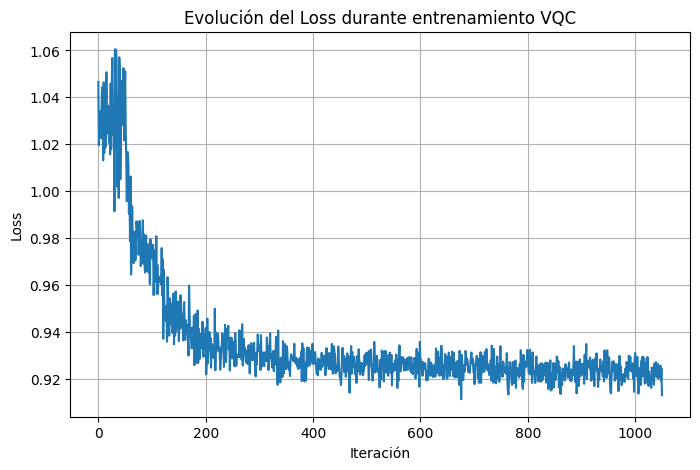

In [40]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [41]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_spsa_200_2 = accuracy_score(y_test_1, y_pred)
prec_vqc_spsa_200_2 = precision_score(y_test_1, y_pred)
recall_vqc_spsa_200_2 = recall_score(y_test_1, y_pred)
f1_vqc_spsa_200_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_spsa_200_2)
print("Precisión:", prec_vqc_spsa_200_2)
print("Recall:", recall_vqc_spsa_200_2)
print("F1 score:", f1_vqc_spsa_200_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.55
Precisión: 0.5652173913043478
Recall: 0.43333333333333335
F1 score: 0.49056603773584906
              precision    recall  f1-score   support

         0.0       0.54      0.67      0.60        30
         1.0       0.57      0.43      0.49        30

    accuracy                           0.55        60
   macro avg       0.55      0.55      0.54        60
weighted avg       0.55      0.55      0.54        60



### 500 datos

In [42]:
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### Regresión Lineal

In [43]:
# Creamos y entrenamos el modelo de regresión logística.
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_1, y_train_1)

LogisticRegression(max_iter=1000)

In [44]:
# Hacemos las predicciones.
y_lr_pred_1 = lr.predict(x_test_1)

# Calculamos métricas.
acc_lr_500_2 = accuracy_score(y_test_1, y_lr_pred_1)
print("Accuracy:", acc_lr_500_2)
prec_lr_500_2 = precision_score(y_test_1, y_lr_pred_1)
print("Precisión:", prec_lr_500_2)
recall_lr_500_2 = recall_score(y_test_1, y_lr_pred_1)
print("Recall:", recall_lr_500_2)
f1_lr_500_2 = f1_score(y_test_1, y_lr_pred_1)
print("F1 Score:", f1_lr_500_2)
print(classification_report(y_test_1, y_lr_pred_1))

Accuracy: 0.8333333333333334
Precisión: 0.8571428571428571
Recall: 0.8
F1 Score: 0.8275862068965518
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84        75
         1.0       0.86      0.80      0.83        75

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



#### VQC con COBYLA

In [45]:
# Escalamos los datos entre 0 y 2 * pi por estar utilizando ángulos.
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
x_train_scaled = scaler.fit_transform(x_train_1)
x_test_scaled = scaler.transform(x_test_1)

# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

In [46]:
# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con COBYLA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0263
Loss: 1.0219
Loss: 1.0175
Loss: 1.0255
Loss: 1.0094
Loss: 1.0065
Loss: 1.0215
Loss: 1.0167
Loss: 1.0056
Loss: 1.0055
Loss: 1.0029
Loss: 1.0017
Loss: 1.0048
Loss: 0.9968
Loss: 1.0006
Loss: 1.0012
Loss: 1.0076
Loss: 1.0001
Loss: 1.0039
Loss: 1.0007
Loss: 0.9983
Loss: 0.9979
Loss: 1.0026
Loss: 0.9981
Loss: 0.9989
Loss: 0.9953
Loss: 0.9999
Loss: 0.9976
Loss: 1.0016
Loss: 0.9968
Loss: 1.0053
Loss: 1.0162
Loss: 1.0004
Loss: 0.9934
Loss: 0.9953
Loss: 0.9981
Loss: 0.9898
Loss: 0.9936
Loss: 1.0020
Loss: 0.9875
Loss: 0.9892
Loss: 0.9869
Loss: 0.9963
Loss: 0.9989
Loss: 0.9898
Loss: 1.0003
Loss: 0.9874
Loss: 0.9893
Loss: 0.9921
Loss: 0.9927
Loss: 0.9904
Loss: 0.9940
Loss: 0.9921
Loss: 0.9923
Loss: 0.9885
Loss: 1.0008
Loss: 0.9928
Loss: 1.0023
Loss: 0.9932
Loss: 0.9915
Loss: 0.9943
Loss: 0.9914
Loss: 0.9943
Loss: 0.9913
Loss: 0.9901
Loss: 0.9876
Loss: 0.9954
Loss: 0.9894
Loss: 0.9894
Loss: 0.9904
Loss: 0.9967
Loss: 0.9884
Loss: 0.9894
Loss: 0.9907
Loss: 0.9968
Loss: 0.9920
Loss: 0.9945

Tiempo: 21m

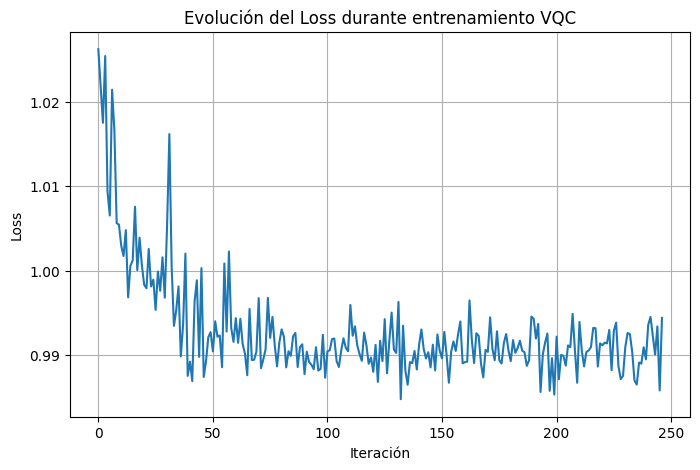

In [47]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [48]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_cobyla_500_2 = accuracy_score(y_test_1, y_pred)
prec_vqc_cobyla_500_2 = precision_score(y_test_1, y_pred)
recall_vqc_cobyla_500_2 = recall_score(y_test_1, y_pred)
f1_vqc_cobyla_500_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_cobyla_500_2)
print("Precisión:", prec_vqc_cobyla_500_2)
print("Recall:", recall_vqc_cobyla_500_2)
print("F1 score:", f1_vqc_cobyla_500_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.5333333333333333
Precisión: 0.5301204819277109
Recall: 0.5866666666666667
F1 score: 0.5569620253164557
              precision    recall  f1-score   support

         0.0       0.54      0.48      0.51        75
         1.0       0.53      0.59      0.56        75

    accuracy                           0.53       150
   macro avg       0.53      0.53      0.53       150
weighted avg       0.53      0.53      0.53       150



#### VQC con SPSA

In [49]:
# Definimos el mapa de características.
feature_map = ZZFeatureMap(feature_dimension=x_train_scaled.shape[1], reps=3)

# Ahora el ansatz.
ansatz = TwoLocal(num_qubits=x_train_scaled.shape[1], reps=3, rotation_blocks='ry', entanglement_blocks='cz')

In [50]:
# Usamos un sampler para el backend.
sampler = AerSampler()

losses = []

# Creamos el modelo VQC con SPSA.
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=SPSA(maxiter=500),
    sampler=sampler,
    initial_point=np.random.rand(ansatz.num_parameters),
    callback=callback,
)

# Y entrenamos.
vqc.fit(x_train_scaled, y_train_1)

Loss: 1.0188
Loss: 1.0180
Loss: 1.0280
Loss: 1.0211
Loss: 1.0227
Loss: 1.0203
Loss: 1.0094
Loss: 1.0274
Loss: 1.0198
Loss: 1.0236
Loss: 1.0270
Loss: 1.0182
Loss: 1.0204
Loss: 1.0186
Loss: 1.0215
Loss: 1.0198
Loss: 1.0146
Loss: 1.0292
Loss: 1.0156
Loss: 1.0164
Loss: 1.0203
Loss: 1.0248
Loss: 1.0222
Loss: 1.0203
Loss: 1.0242
Loss: 1.0224
Loss: 1.0181
Loss: 1.0261
Loss: 1.0292
Loss: 1.0218
Loss: 1.0126
Loss: 1.0220
Loss: 1.0278
Loss: 1.0107
Loss: 1.0127
Loss: 1.0280
Loss: 1.0229
Loss: 1.0265
Loss: 1.0139
Loss: 1.0239
Loss: 1.0175
Loss: 1.0203
Loss: 1.0276
Loss: 1.0235
Loss: 1.0251
Loss: 1.0168
Loss: 1.0188
Loss: 1.0253
Loss: 1.0244
Loss: 1.0190
Loss: 1.0220
Loss: 1.0251
Loss: 1.0173
Loss: 1.0112
Loss: 1.0142
Loss: 1.0071
Loss: 1.0093
Loss: 1.0109
Loss: 1.0049
Loss: 1.0088
Loss: 1.0068
Loss: 1.0037
Loss: 1.0005
Loss: 1.0058
Loss: 1.0092
Loss: 0.9981
Loss: 1.0085
Loss: 1.0000
Loss: 0.9946
Loss: 1.0056
Loss: 0.9922
Loss: 0.9888
Loss: 0.9890
Loss: 0.9863
Loss: 0.9881
Loss: 0.9918
Loss: 0.9910

Tiempo: 1h 25m

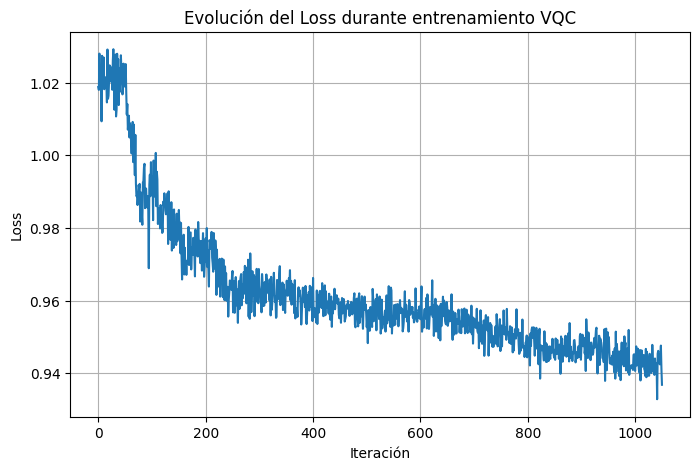

In [51]:
# Graficamos la evolución del loss
plt.figure(figsize=(8,5))
plt.plot(losses, linestyle='-')
plt.title('Evolución del Loss durante entrenamiento VQC')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [52]:
# Mostramos ahora los resultados.
y_pred = vqc.predict(x_test_scaled)

acc_vqc_spsa_500_2 = accuracy_score(y_test_1, y_pred)
prec_vqc_spsa_500_2 = precision_score(y_test_1, y_pred)
recall_vqc_spsa_500_2 = recall_score(y_test_1, y_pred)
f1_vqc_spsa_500_2 = f1_score(y_test_1, y_pred)

print("Accuracy:", acc_vqc_spsa_500_2)
print("Precisión:", prec_vqc_spsa_500_2)
print("Recall:", recall_vqc_spsa_500_2)
print("F1 score:", f1_vqc_spsa_500_2)
print(classification_report(y_test_1, y_pred))

Accuracy: 0.56
Precisión: 0.5555555555555556
Recall: 0.6
F1 score: 0.576923076923077
              precision    recall  f1-score   support

         0.0       0.57      0.52      0.54        75
         1.0       0.56      0.60      0.58        75

    accuracy                           0.56       150
   macro avg       0.56      0.56      0.56       150
weighted avg       0.56      0.56      0.56       150



## Resultados

### Accuracy (Desbalanceado)

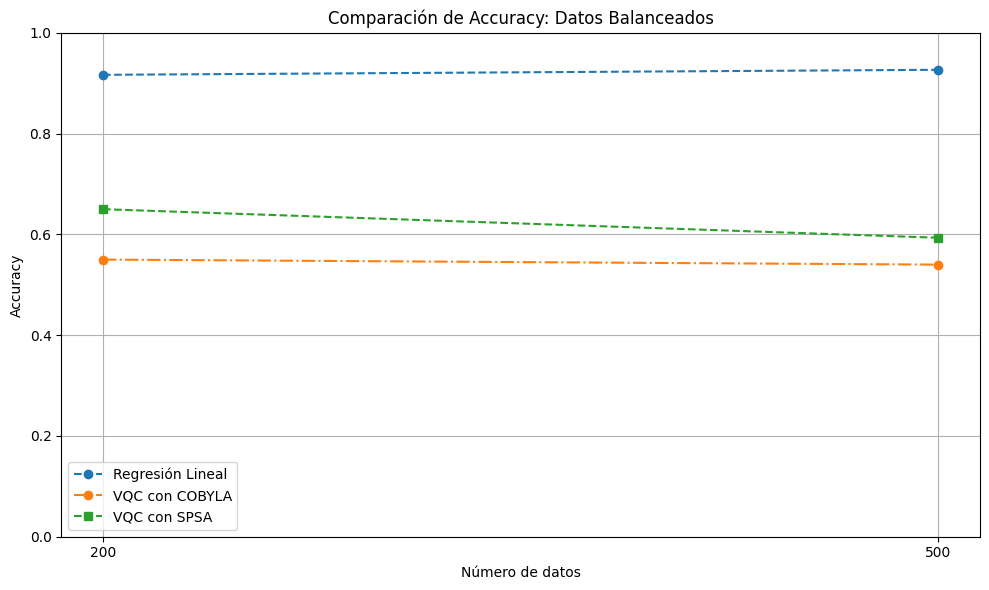

In [59]:
import matplotlib.pyplot as plt

# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
acc_lr = [acc_lr_200_1, acc_lr_500_1]
acc_vqc_cobyla = [acc_vqc_cobyla_200_1, acc_vqc_cobyla_500_1]
acc_vqc_spsa = [acc_vqc_spsa_200_1, acc_vqc_spsa_500_1]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_lr, marker='o', linestyle='--', label='Regresión Lineal')
plt.plot(num_datos, acc_vqc_cobyla, marker='o', linestyle='-.', label='VQC con COBYLA')
plt.plot(num_datos, acc_vqc_spsa, marker='s', linestyle='--', label='VQC con SPSA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: Datos Balanceados')
plt.xticks([200, 500])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score (Desbalanceado)

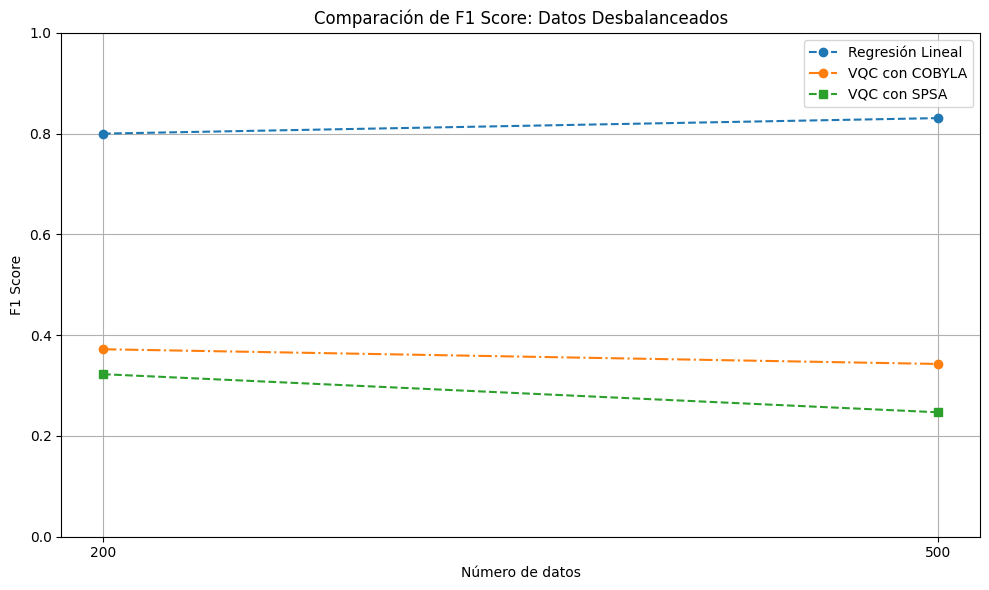

In [58]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
f1_lr = [f1_lr_200_1, f1_lr_500_1]
f1_vqc_cobyla = [f1_vqc_cobyla_200_1, f1_vqc_cobyla_500_1]
f1_vqc_spsa = [f1_vqc_spsa_200_1, f1_vqc_spsa_500_1]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_lr, marker='o', linestyle='--', label='Regresión Lineal')
plt.plot(num_datos, f1_vqc_cobyla, marker='o', linestyle='-.', label='VQC con COBYLA')
plt.plot(num_datos, f1_vqc_spsa, marker='s', linestyle='--', label='VQC con SPSA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: Datos Desbalanceados')
plt.xticks([200, 500])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Accuracy (Sin Desbalanceo)

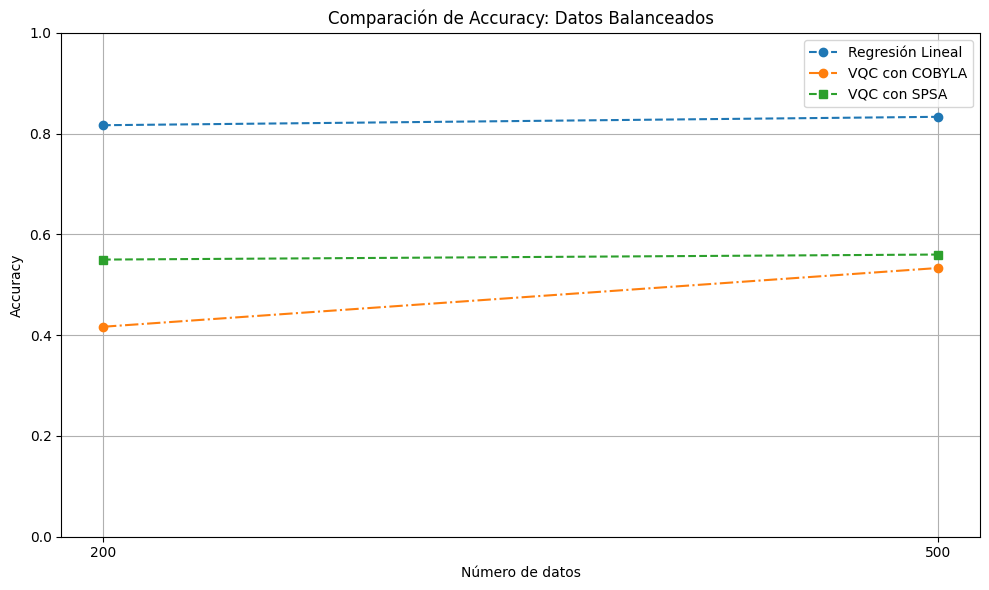

In [60]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
acc_lr = [acc_lr_200_2, acc_lr_500_2]
acc_vqc_cobyla = [acc_vqc_cobyla_200_2, acc_vqc_cobyla_500_2]
acc_vqc_spsa = [acc_vqc_spsa_200_2, acc_vqc_spsa_500_2]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_lr, marker='o', linestyle='--', label='Regresión Lineal')
plt.plot(num_datos, acc_vqc_cobyla, marker='o', linestyle='-.', label='VQC con COBYLA')
plt.plot(num_datos, acc_vqc_spsa, marker='s', linestyle='--', label='VQC con SPSA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: Datos Balanceados')
plt.xticks([200, 500])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score (Sin Desbalanceo)

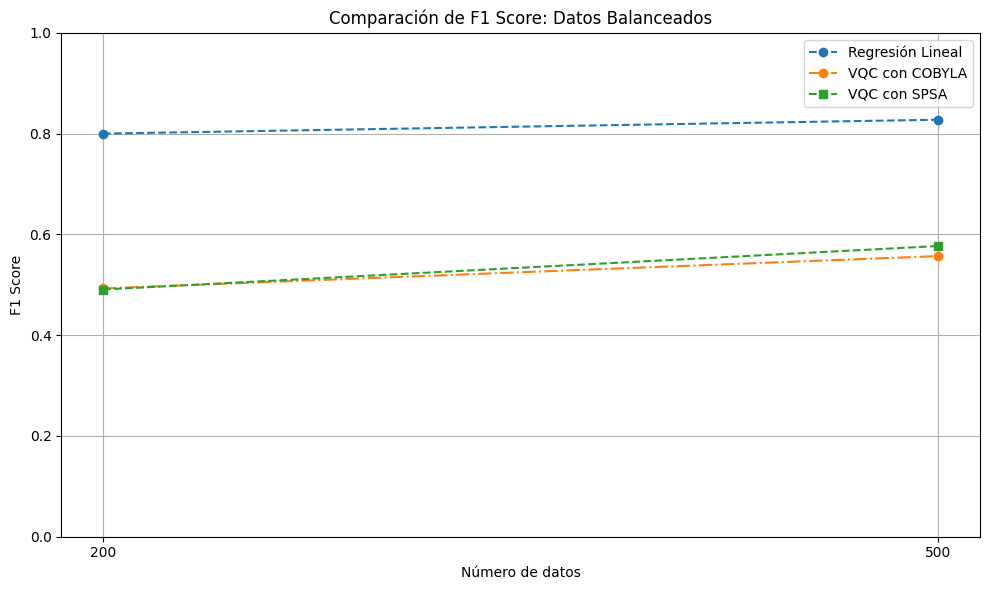

In [61]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
f1_lr = [f1_lr_200_2, f1_lr_500_2]
f1_vqc_cobyla = [f1_vqc_cobyla_200_2, f1_vqc_cobyla_500_2]
f1_vqc_spsa = [f1_vqc_spsa_200_2, f1_vqc_spsa_500_2]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_lr, marker='o', linestyle='--', label='Regresión Lineal')
plt.plot(num_datos, f1_vqc_cobyla, marker='o', linestyle='-.', label='VQC con COBYLA')
plt.plot(num_datos, f1_vqc_spsa, marker='s', linestyle='--', label='VQC con SPSA')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: Datos Balanceados')
plt.xticks([200, 500])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()